In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.12.0
using device: cuda


In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print(data.shape)
data.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

raw_numpy= data.to_numpy()
np.random.shuffle(raw_numpy)
raw_torch = torch.tensor(raw_numpy)
X = raw_torch[:, 1:].type(torch.float) / 255.
y = raw_torch[:, 0].type(torch.long)
print(f"X.shape: {X.shape}, y.shape, {y.shape}")
train_split = int(0.8*len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X.shape: torch.Size([42000, 784]), y.shape, torch.Size([42000])


(torch.Size([33600, 784]),
 torch.Size([8400, 784]),
 torch.Size([33600]),
 torch.Size([8400]))

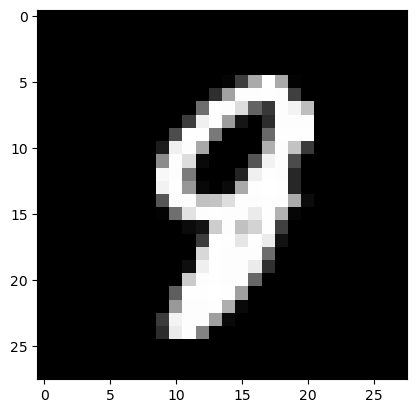

In [4]:
plt.gray()
plt.imshow(X_train[5].cpu().reshape((28, 28)), interpolation='nearest')
plt.show()

In [5]:
class MNISTModel(nn.Module):
    def __init__(self, hidden_units: int = 10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=784, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=10))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

#Hyper parameters!!!
lr = 0.1
epochs = 200
# lr_decay = 0.5
model = MNISTModel().to(device)
print(f'model parameters are on device: {next(model.parameters()).device}')
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr = lr)
loss_fn = nn.CrossEntropyLoss()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

model parameters are on device: cuda:0


In [6]:
for epoch in range(epochs):
    model.train()
    #1. Forward Pass
    y_logits = model(X_train)
    
    #2. Calculate Loss/Accuracy
    loss = loss_fn(y_logits, y_train)
    #3. Optimize zero grad
    optimizer.zero_grad()
    #4. Perform backpropagation
    loss.backward()
    #5. Step the optimizer
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_loss = loss_fn(test_logits, y_test)
        
        train_pred_labels = torch.argmax(y_logits, dim=1)
        test_pred_labels = torch.argmax(test_logits, dim=1)
        train_acc = accuracy_fn(y_true = y_train,
                                y_pred = train_pred_labels)
        test_acc = accuracy_fn(y_true = y_test,
                                y_pred = test_pred_labels)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, accuracy: {train_acc:.3f}% | Test Loss: {test_loss:.5f}, accuracy: {test_acc:.3f}%")


Epoch: 0 | Train Loss: 2.31237, accuracy: 12.783% | Test Loss: 2.29261, accuracy: 15.583%
Epoch: 10 | Train Loss: 2.06204, accuracy: 34.143% | Test Loss: 2.04070, accuracy: 37.381%
Epoch: 20 | Train Loss: 1.81093, accuracy: 51.976% | Test Loss: 1.78824, accuracy: 52.631%
Epoch: 30 | Train Loss: 1.55192, accuracy: 63.292% | Test Loss: 1.52852, accuracy: 63.905%
Epoch: 40 | Train Loss: 1.30273, accuracy: 69.595% | Test Loss: 1.28378, accuracy: 70.107%
Epoch: 50 | Train Loss: 1.09699, accuracy: 75.092% | Test Loss: 1.08493, accuracy: 75.250%
Epoch: 60 | Train Loss: 0.94298, accuracy: 79.042% | Test Loss: 0.93680, accuracy: 79.060%
Epoch: 70 | Train Loss: 0.83085, accuracy: 81.649% | Test Loss: 0.82898, accuracy: 81.155%
Epoch: 80 | Train Loss: 0.74854, accuracy: 83.211% | Test Loss: 0.74965, accuracy: 82.548%
Epoch: 90 | Train Loss: 0.68672, accuracy: 84.193% | Test Loss: 0.68985, accuracy: 83.774%
Epoch: 100 | Train Loss: 0.63907, accuracy: 85.030% | Test Loss: 0.64357, accuracy: 84.667%